# Roman Urdu Sentiment Analysis

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# Any results you write to the current directory are saved as output.

### **GOAL**
* Train a sentiment classifier (Positive, Negative, Neutral) on a corpus of the provided dataset below. 
* Maximize accuracy of the classifier with a special interest in being able to accurately detect negative sentiment.

### **Data Set Description** 
Classifier model developed below uses a dataset obtained form UCI Machine Learning Repository located <a href="http://archive.ics.uci.edu/ml/datasets/Roman+Urdu+Data+Set">here</a>

This dataset is authored by Zareen Sharf, from Shaheed Zulfiqar Ali Bhutto Institute of Science and Technology (SZABIST). Data set contains sentences in Urdu languate and it is tagged for sentiements either, Positive, Negative, or Neutral.

Sentences in Urdu are written in plain English for word processing rather than native Urdu fonts. Data includes documents from a wide variety of sources, not merely social media, and some of it may be inconsistently
labeled.

### **Plan of Work** 

Sentiment analysis involves the following stages. 

* Loading and cleaning the data
* Exploratory data analysis
* Ommiting stop words or common words
* Creating new features
* Plotting most frequently used words
* Vectorizing sentences to build a matrix
* Training and testing the machine learning model
* Evaluating the machine learning model accuracy

In [2]:
# Loading required python packages and libraries
import nltk
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import pickle
import random
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import keras
from keras import Sequential
from keras.models import Model
import numpy as np
from keras.layers import Dense, Dropout, LSTM, Bidirectional, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import gensim.models.keyedvectors as word2vec #need to use due to depreceated model
from nltk.tokenize import RegexpTokenizer

from keras_preprocessing.sequence import pad_sequences

from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM
from keras.models import Sequential
from wordcloud import WordCloud,STOPWORDS
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Word2vec
import gensim
stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

In [3]:
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 32
BATCH_SIZE = 1024



# Load the csv file using Pandas and print first 5 lines
#data = pd.read_csv(r"C:\Users\PC\Desktop\sentiments\Roman Urdu DataSet.csv",header=None)
data = pd.read_csv(r"C:\Users\PC\Desktop\sentiments\data set 1.csv",header=None)
data.head()

,0,1
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive
1,sahi bt h,Positive
2,"Kya bt hai,",Positive
3,Wah je wah,Positive
4,Are wha kaya bat hai,Positive


### **Data Preprocessing**

In this step, data is preprocessed or cleaned for missing column names, incorrect values of sentiments, null values present in the text body. 

In [4]:
# Adding column names
data.columns =['body_text','sentiment']

In [5]:
# Print unique values in column 1 and 2
print ('Unique values of the sentiments are', data.sentiment.unique())
#print ('Unique values of the unknonwn column are', data.unknown.unique())

Unique values of the sentiments are ['Positive' 'Negative']


In [6]:
# 'Neative' sentiment will be most likely Negative, so it is replaced accordingly. 
data[data['sentiment']=='Neative']='Negative'

In [7]:
# Verify we replaced all the 'Neative'
print ('Unique values of the sentiments are', data.sentiment.unique())

Unique values of the sentiments are ['Positive' 'Negative']


In [8]:
# Checking Null values in the data
data.isna().sum()

body_text    0
sentiment    0
dtype: int64

In [9]:
# Dropping the text body row which has a null value
data = data.dropna(subset=['body_text'])

In [10]:
# Last column can be dropped as it does not contain any useful information. Here axis=1, means column. 
#data = data.drop('unknown', axis=1)

In [11]:
data.head()

,body_text,sentiment
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive
1,sahi bt h,Positive
2,"Kya bt hai,",Positive
3,Wah je wah,Positive
4,Are wha kaya bat hai,Positive


In [12]:
data.describe()

,body_text,sentiment
count,11300,11300
unique,11095,2
top,Good,Positive
freq,23,6013


### **Data Exploration**

From the data of sentiments, it looks like it is not balanced. There are more neutral comments than positive and negative comments. When the class distribution is unbalanced, accuracy is considered a poor choice of evaluation of classifier. This is due the fact that, it gives high scores to models which just predict the most frequent class.

Number of sentiments in each category are as below
Positive    6013
Negative    5287
Name: sentiment, dtype: int64

Perecentage sentiments in each category are as below
Positive    53.212389
Negative    46.787611
Name: sentiment, dtype: float64


<AxesSubplot:>

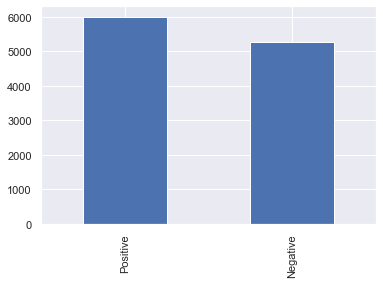

In [13]:
print ('Number of sentiments in each category are as below')
print (data.sentiment.value_counts())

print ('\nPerecentage sentiments in each category are as below')
print (data.sentiment.value_counts()/data.shape[0]*100)

data.sentiment.value_counts().plot(kind='bar')

In [14]:
# Dropping neutral sentiment sentences. 
data = data[data.sentiment != 'Neutral']

In [15]:
data = data.reset_index(drop=True)

In [16]:
data.head()

,body_text,sentiment
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive
1,sahi bt h,Positive
2,"Kya bt hai,",Positive
3,Wah je wah,Positive
4,Are wha kaya bat hai,Positive


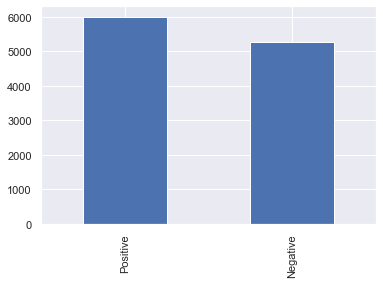

In [17]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

data.sentiment.value_counts().plot(kind='bar')
reviews = data.body_text
label = data.sentiment
#label_encoder = LabelEncoder()
#Y = label_encoder.fit_transform(Y)
#Y = to_categorical(Y)

In [18]:
data.describe()

,body_text,sentiment
count,11300,11300
unique,11095,2
top,Good,Positive
freq,23,6013


In [19]:
UrduStopWordList = [line.rstrip('\n') for line in open(r'C:\Users\PC\Desktop\sentiments\stopwords.txt')]

print (UrduStopWordList)

['nahi', 'nhi', 'nh', 'ney', 'nai', 'nay', 'chi', 'ni', 'na', 'k', 'ye', 'to', 'hai', 'i', 'kisi', 'sy', 'hain', 'or', 'tak', 'ek', 'aik', 'kiya', 'liya', 'diya', 'dete', 'unhon', 'unhen', 'sey', 'kiye', 'mujhe', 'mjhe', 'bana', 'hue', 'aur', 'wo', 'u', 'aa', 'woh', 'ai', 'aisa', 'waisa', 'mera', 'mere', 'mery', 'meri', 'muzhe', 'mai', 'hum', 'khud', 'acha', 'per', 'har', 'tag', 'bat', 'baat', 'pr', 'he', 'hamara', 'jahan', 'tumhara', 'tm', 'apka', 'apke', 'walon', 'lekin', 'lakin', 'kitna', 'ke', 'hota', 'hon', 'kab', 'kb', 'kabhi', 'sirf', 'hoti', 'hote', 'magar', 'app', 'agar', 'agr', 'pta', 'jab', 'inhe', 'inho', 'o', 'in', 'sath', 'esa', 'kaha', 'key', 'kahan', 'jis', 'kia', 'ayi', 'hy', 'main', 'mein', 'me', 'hein', 'hn', 'ki', 'tha', 'ta', 'koi', 'ko', 'woh ', 'bhi', 'py', 'yeh', 'raha', 'rha', 'hota', 'ho', 'ga', 'g', 'ka', 'leye', 'lye', 'kr', 'kar', 'kry', 'ker', 'lye', 'liye', 'liya', 'hotay', 'waisay', 'gya', 'gaya', 'gae', 'kch', 'kuch', 'ab', 'q', 'in', 'a', 'and', 'they'

In [20]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in UrduStopWordList:
                tokens.append(token)
    return " ".join(tokens)

In [21]:
data.body_text = data.body_text.apply(lambda x: preprocess(x))
data.body_text.head(10)

0      sai kha her bus hal kal bi aj aj bi aus say bus
1                                              sahi bt
2                                                   bt
3                                           wah je wah
4                                         are wha kaya
5                                            wah likhi
6                                wha itni sari khubiya
7                                         itni khubiya
8                allah rehm farma zalimo hidayat ameen
9    please everyone allah s w t naam hamesha bary ...
Name: body_text, dtype: object

Feature Extraction
Bag of words / Countvectorizer:
It converts a collection of reviews to a matrix of the counts of occurences of each word in the corpus(set of reviews).

In [22]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
corpus = []
for i in range(0,11300):
  review = re.sub('[^a-zA-Z]', ' ', data['body_text'][i]) # A-Z'ye olmayanları boşlukla değiştir
  review = review.lower() # hepsini küçük harfe çevir
  review = review.split() #split sadece boşluklara göre ayırır
  ps = PorterStemmer()
  
  review = [ps.stem(word) for word in review if not word in UrduStopWordList]
  review = ' '.join(review)
  corpus.append(review)

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 1500)
X = cv.fit_transform(corpus).toarray()
y = data.iloc[:,-1].values

In [24]:
len(y)

11300

In [25]:
len(X)

11300

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [27]:
X_train.shape

(9040, 1500)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model_dec = DecisionTreeClassifier(max_depth=500, random_state=0)
model_dec.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score, roc_auc_score

y_pred_rf = model_dec.predict(X_test)

acc = accuracy_score(y_test, y_pred_rf)
precision, recall, fscore, train_support = score(y_test, y_pred_rf, labels='Positive', average='macro')


print('Precision: {} / Recall: {} / F1 score: {} /Accuracy: {}'.format(round(precision, 3), round(recall, 3), round(fscore, 3),\
                                                                       round(acc,3))) 
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred_rf)
print(cm)
accuracy_score(y_test, y_pred_rf)

Embedding layer

In [ ]:
max_words = 10000  # max unique words in the dataset

embedding_dim = 200
embedding_matrix3 = np.zeros((vocab_size, embedding_dim))
for word, i in  tokenizer.word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix3[i] = embedding_vector

In [ ]:
print(embedding_matrix3.shape)

In [ ]:
embedding_layer = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix3], input_length=SEQUENCE_LENGTH, trainable=False)

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


Compile model


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['acc',f1_m,precision_m, recall_m])

Callbacks

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

Train

In [ ]:
#history = model.fit(x_train, y_train,
                #    batch_size=BATCH_SIZE,
                #    epochs=EPOCHS,
                #    validation_split=0.1,
                #    verbose=1,
                 #   callbacks=callbacks)
batch_size = 32
history=model.fit(x_train, y_train, epochs =8 , batch_size=batch_size, verbose = 2)
                    # epochs=EPOCHS,

In [ ]:
#score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)

loss, accuracy, f1_score, precision, recall =model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY: ",accuracy)
print("f1_score: ",f1_score)
print("precision: ",precision)
print("recall: ",recall)
print("LOSS: ",loss)